## Semantic Search

* Here we will build a search engine over a PDF document. This will allow us to retrieve passages in the PDF that are similar to an input query.

* Concepts
    * Documents and document loaders
    * Text splitters
    * Embeddings
    * Vector stores and retrievers

In [1]:
# pip install  pypdf arabic_reshaper bidi langgraph pdfplumber pytesseract pillow langchain

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = ""


In [ ]:
# with open("all_splits.pkl", "rb") as f:
#     all_splits = pickle.load(f)

In [21]:
from langchain_core.prompts import ChatPromptTemplate

# Build your own system prompt in Arabic or adjusted tone
custom_prompt = ChatPromptTemplate.from_messages([
    ("system",  "أنت رجل فى غايه الذكاء مقدم لك بيانات لتستمد منها اجاباتك بناء على سؤال مقدم لك واعلم انه يوجد ايات قرءانية مكتوبه بطريقه خطأ لا تستمد منها "),
    ("human", "استخدم السياق التالي للإجابة على السؤال:\n\n{context}\n\nالسؤال: {question}\n\nالإجابة:")
])



In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import DashScopeEmbeddings  # Changed this
from langchain import hub
import bs4

# Configure API key
dashscope_api_key = ""
dashscope_base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1"

embeddings = DashScopeEmbeddings(
    dashscope_api_key=dashscope_api_key,
    model="text-embedding-v1"  # DashScope's embedding model
)

# Create vectorstore
vector_store = Chroma(embedding_function=embeddings)
_ = vector_store.add_documents(documents=all_splits)

retriever = vector_store.as_retriever(   
    search_type="similarity",    # or "mmr", "similarity_score_threshold"
    search_kwargs={"k": 1}       # how many results to retrieve
)

#### RETRIEVAL and GENERATION ####
prompt = custom_prompt


# Configure LLM for DashScope
llm = ChatOpenAI(
    model_name="qwen-plus",  # or whatever model you have access to
    openai_api_key=dashscope_api_key,
    openai_api_base=dashscope_base_url,
    temperature=0
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
response = rag_chain.invoke("ما هى أحكام الوضوء ؟")
print(response)

من خلال السياق المقدم، يمكننا استخلاص أحكام الوضوء كما يلي:

1. **غسل الوجه**: يجب غسل الوجه بالماء باستخدام الكفين لنقل الماء إلى الوجه.

2. **غسل اليدين**: يتم غسل اليدين إلى المرفقين، اليمنى أولاً ثم اليسرى. يستحب استخدام الغرفة (الكوب أو الإناء) عند غسل كل يد على حدة.

3. **مسح الرأس**: يجب مسح الرأس مرة واحدة باليدين بعد غسل اليدين.

4. **غسل الرجلين**: يجب غسل الرجلين إلى الكعبين ثلاث مرات لكل رجل، beginning باليمين ثم اليسار.

5. **التتابع**: الترتيب المذكور في السنة النبوية هو تتابع معين: الوجه، اليدين، مسح الرأس، ثم غسل الرجلين.

6. **النية**:虽说 لم يذكر صراحة في النص، إلا أن النية من أساسيات الوضوء في الفقه الإسلامي.

7. **استخدام الماء الطاهر**: يجب استخدام الماء الطاهر للوضوء. وإذا لم يوجد ماء، يجوز التيمم بصعيد طيب (تراب نظيف).

8. **عدد الغسلات**: يستحب غسل الأعضاء ثلاث مرات، إلا الرأس الذي يمسح مرة واحدة.

9. **التسمية**: من المستحب أيضاً أن يقول المسلم "بسم الله" قبل البدء بالوضوء.

هذه هي الأحكام المستخلصة من النصوص المقدمة والتي توضح كيفية وأهمية الوضوء الصحيح.


In [25]:
text = "متى تصوم الحائض ؟"
response = rag_chain.invoke(text)
print(response)

الحائض لا تصوم أثناء فترة الحيض، لأن الصيام ليس مستحقًا对她 خلال هذه الفترة. وبعد انتهاء الحيض، يُصبح عليها قضاء الأيام التي أفطرتها بسبب الحيض بعد أن تتطهر (بإتمام الغسل وما إلى ذلك)، ولكنها ليست ملزمة بصيام هذه الأيام في أوقات محددة طالما تقضيها قبل حلول نفس الشهر من العام المقبل.

**الاستناد إلى النصوص المقدمة:**
- الحديث الذي روي عن النبي ﷺ يوضح للمرأة المستحاضة أو الحائض كيف تتصرف بشأن الصلاة والطهارة، وهذا يمكن تعميمه أيضًا على الصيام بناءً على الأدلة الشرعية الأخرى.
- قال النبي ﷺ: "فإذا تطهرّن فاتوهن من حيث أمركم الله". هذا يعني أنه بعد الطهر يجب استئناف العبادات المفروضة مثل الصلاة والصيام.

وبالتالي، الإجابة هي: **تصوم الحائض بعد أن تنتهي من حيضها وتطهر، ثم تقوم بقضاء الأيام التي أفطرتها بسبب الحيض في أي وقت آخر قبل حلول رمضان القادم.**


In [ ]:
from typing import Literal
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict



# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(
    model_name="qwen-max",  # or whatever model you have access to
    openai_api_key=dashscope_api_key,
    openai_api_base=dashscope_base_url,
    temperature=0
)

# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return "answer": response.content


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


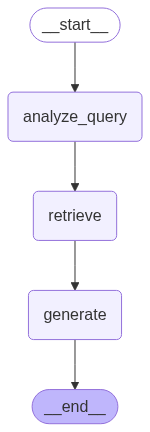

In [6]:
graph

In [7]:
for step in graph.stream(
    {"question": "الصلاة "},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")




BadRequestError: Error code: 400 - {'error': {'code': 'invalid_parameter_error', 'param': None, 'message': "<400> InternalError.Algo.InvalidParameter: 'messages' must contain the word 'json' in some form, to use 'response_format' of type 'json_object'.", 'type': 'invalid_request_error'}, 'id': 'chatcmpl-81f60d76-90c4-9d5d-9949-969caf35b39d', 'request_id': '81f60d76-90c4-9d5d-9949-969caf35b39d'}

In [10]:
from typing import Literal
from typing_extensions import Annotated, List, TypedDict

from langgraph.graph import START, StateGraph
from langchain import hub
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain.chat_models import ChatOpenAI
from bs4 import BeautifulSoup as bs

# ✅ Load documents

# ✅ Assign metadata tags ("beginning", "middle", "end")
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# ✅ Initialize vector store and add documents
embeddings = DashScopeEmbeddings(
    dashscope_api_key=dashscope_api_key,
    model="text-embedding-v1"  # DashScope's embedding model
)

# Create vectorstore
vector_store = Chroma(embedding_function=embeddings)
_ = vector_store.add_documents(documents=all_splits)


# ✅ Define structured output schema for user query
class Search(TypedDict):
    """Structured search schema."""
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section of the text to query.",
    ]

# ✅ Define conversational LLM with JSON support (Dashscope/Qwen)
dashscope_api_key = "sk-a3cde32217314715adb67f38f2d23723"
dashscope_base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1"


llm = ChatOpenAI(
    model_name="qwen-max",
    openai_api_key=dashscope_api_key,
    openai_api_base=dashscope_base_url,
    temperature=0,
)

# ✅ Load a RAG prompt from LangChain hub
prompt = hub.pull("rlm/rag-prompt")

# ✅ Define application state type
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

# ✅ Step 1: Use LLM to extract structured query (must include JSON instruction)
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(
        Search,
        system_message="You are an assistant that extracts search queries and tags based on user questions. Respond with a JSON object in the format: {\"query\": ..., \"section\": ...}."
    )
    query = structured_llm.invoke(state["question"])
    return {"query": query}

# ✅ Step 2: Retrieve relevant documents based on query & section
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

# ✅ Step 3: Generate an answer based on retrieved docs & question
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# ✅ Build the LangGraph pipeline
graph_builder = StateGraph(State)
graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.set_entry_point("analyze_query")
graph_builder.add_edge("analyze_query", "retrieve")
graph_builder.add_edge("retrieve", "generate")

graph = graph_builder.compile()

# ✅ Run as a stream
for step in graph.stream(
    {"question": "ما هي الصلاة؟ أجب بصيغة JSON."},  # Arabic question + JSON instruction!
    stream_mode="updates",
):
    print(step)
    print("\n" + "-" * 30 + "\n")


C:\Users\Yalla\AppData\Local\Temp\ipykernel_6540\676520925.py:53: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


ValueError: Received unsupported arguments {'system_message': 'You are an assistant that extracts search queries and tags based on user questions. Respond with a JSON object in the format: {"query": ..., "section": ...}.'}